In [1]:
import json
import csv

import sys
sys.path.append("../../")
#sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

torch.set_default_tensor_type(torch.DoubleTensor)

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

dm.Utilities.set_compute_backend('keops')


In [2]:
import pykeops
#pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_torch_bindings()  

Compiling libKeOpstorch205c85ff5b in /users/home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorch205c85ff5b:
       formula: Sum_Reduction(SqNorm2(x - y),1)
       aliases: x = Vi(0,3); y = Vj(1,3); 
       dtype  : float32
... Done.

pyKeOps with torch bindings is working!



In [3]:
sys.version

'3.6.8 (default, Oct  7 2019, 12:59:55) \n[GCC 8.3.0]'

In [4]:
print(torch.__version__)

1.4.0


In [5]:
print(pykeops.__version__)

1.3


In [6]:
from PIL import Image
path_image = '/users/home/gris/Data/Multishape/'
source = torch.tensor(np.asarray(Image.open(path_image + "Lung_Moving.tif")))
target = torch.tensor(np.asarray(Image.open(path_image + "Lung_Fixed.tif")))

# load boundaries from csv file
from numpy import loadtxt
boundary0_pix = torch.tensor(loadtxt('boundary0.csv', delimiter=',')).t()#.flip(dims=[0])
boundary1_pix = torch.tensor(loadtxt('boundary1.csv', delimiter=',')).t()#.flip(dims=[0])


In [7]:
# convert the rgb image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

source_tot = torch.tensor(rgb2gray(source))
target_tot = torch.tensor(rgb2gray(target))

In [8]:
source.shape, target.shape

(torch.Size([400, 400, 3]), torch.Size([404, 408, 3]))

In [9]:
# cropping the target so source and target are of the same size
target_tot = target_tot[2:-2, 4:-4]
target_tot.shape

torch.Size([400, 400])

In [10]:
step=15
source = source_tot[::step, ::step]
target = target_tot[::step, ::step]

In [11]:
source.shape

torch.Size([27, 27])

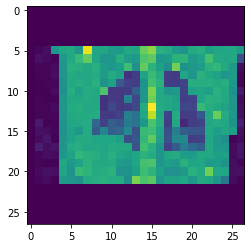

In [14]:
plt.imshow(source)# - target)

In [12]:
source_deformable_tot = dm.Models.DeformableImage(source_tot)
target_deformable_tot = dm.Models.DeformableImage(target_tot)
source_deformable = dm.Models.DeformableImage(source)
target_deformable = dm.Models.DeformableImage(target)

In [13]:
boundary0_pts = dm.Utilities.pixels2points(boundary0_pix, source_deformable_tot.shape, source_deformable_tot.extent)
boundary1_pts = dm.Utilities.pixels2points(boundary1_pix, source_deformable_tot.shape, source_deformable_tot.extent)

boundary0_pts = torch.load(path_image + 'curve_boundary0')
boundary1_pts = torch.load(path_image + 'curve_boundary1')

In [14]:
boundary0_pts.shape

torch.Size([538, 2])

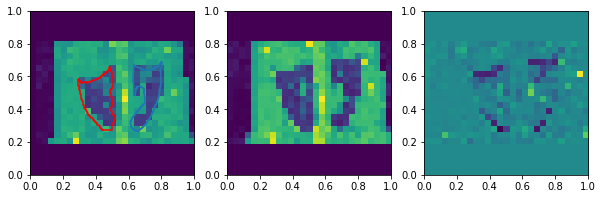

In [15]:
plt.figure(figsize=(10,10))

plt.subplot(1, 3, 1)
plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(boundary0_pts[:,0], boundary0_pts[:,1], '-r')
plt.plot(boundary1_pts[:,0], boundary1_pts[:,1], '-')


plt.subplot(1, 3, 2)
plt.imshow(target_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())

plt.subplot(1, 3, 3)
plt.imshow(target_deformable.geometry[0]-source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())


plt.show()

In [15]:
scale_translation = 10.
translation0 = dm.DeformationModules.Translations(2, 1, scale_translation, gd=torch.tensor([[0.5, 0.5]]))
scale_translation = 10.
translation1 = dm.DeformationModules.Translations(2, 1, scale_translation, gd=torch.tensor([[0.8, 0.6]]))

In [16]:
attach = dm.Attachment.L2NormAttachment(transform=None)

In [17]:
shoot_solver = 'torch_euler'
shoot_it = 10

In [18]:
sigma_bck = 0.2

In [19]:
boundary0 = dm.MultiShape.Boundary(copy.copy(boundary0_pts[::25]))
boundary1 = dm.MultiShape.Boundary(copy.copy(boundary1_pts[::25]))
boundary0.geometry[0].shape

torch.Size([22, 2])

In [20]:
constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0,torch.prod(torch.tensor(boundary0.geometry[0].shape)))#, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1,torch.prod(torch.tensor(boundary1.geometry[0].shape)))#, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])


In [21]:
model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable], [[translation0], [translation1]], [attach], sigma_bck, lam=10., constraints=constraints, backgroundtype='dense')

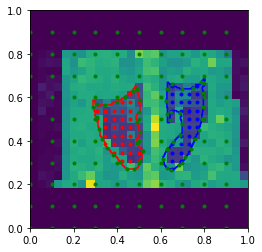

In [23]:
pts0 = model.modules[0].manifold[0].gd.detach()
pts1 = model.modules[1].manifold[0].gd.detach()
pts2 = model.modules[2].manifold[0].gd.detach()

plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(boundary0_pts[:,0], boundary0_pts[:,1], '-r')
plt.plot(boundary1_pts[:,0], boundary1_pts[:,1], '-b')
plt.plot(pts0[:,0], pts0[:,1], '.r')
plt.plot(pts1[:,0], pts1[:,1], '.b')
plt.plot(pts2[:,0], pts2[:,1], '.g')

In [22]:
shoot_solver = 'torch_euler'
shoot_it = 10

In [ ]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

In [ ]:
model.evaluate([target_deformable], shoot_solver, shoot_it)

Compiling libKeOpstorchaeba68d942 in /users/home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchaeba68d942:
       formula: Sum_Reduction(Exp(-S*SqNorm2(x - y)/IntCst(2))*p,0)
       aliases: x = Vi(0,2); y = Vj(1,2); p = Vj(2,2); S = Pm(3,1); 
       dtype  : float64
... Done.
Compiling libKeOpstorch30eff84f24 in /users/home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorch30eff84f24:
       formula: Sum_Reduction(Exp(-S*SqNorm2(x - y)/IntCst(2))*X,0)
       aliases: x = Vi(0,2); y = Vj(1,2); X = Vj(2,2); S = Pm(3,1); 
       dtype  : float64
... Done.
Compiling libKeOpstorch7dc33df00b in /users/home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorch7dc33df00b:
       formula: Sum_Reduction((Exp(-S*SqNorm2(x - y)/IntCst(2))*px | py)/IntCst(2),1)
       aliases: x = Vi(0,2); y = Vj(1,2); px = Vi(2,2); py = Vj(3,2); S = Pm(4,1); 
       dtype  : float64
... Done.
Compiling libKeOpstorchd5e10a17e7 in /users/home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchd5e10a

... Done.
Compiling libKeOpstorchf0c5ed3054 in /users/home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorchf0c5ed3054:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction((Exp(-S*SqNorm2(x - y)/IntCst(2))*px | py)/IntCst(2),1), Var(2,2,0), Var(5,1,1), Var(6,1,1)), Var(1,2,1), Var(7,2,0), Var(8,2,0))
       aliases: x = Vi(0,2); y = Vj(1,2); px = Vi(2,2); py = Vj(3,2); S = Pm(4,1); Var(5,1,1); Var(6,1,1); Var(7,2,0); Var(8,2,0); 
       dtype  : float64
... Done.
Compiling libKeOpstorcha5fdf63b28 in /users/home/gris/.cache/pykeops-1.3-cpython-36/build-libKeOpstorcha5fdf63b28:
       formula: Grad_WithSavedForward(Grad_WithSavedForward(Sum_Reduction((Exp(-S*SqNorm2(x - y)/IntCst(2))*px | py)/IntCst(2),1), Var(2,2,0), Var(5,1,1), Var(6,1,1)), Var(2,2,0), Var(7,2,0), Var(8,2,0))
       aliases: x = Vi(0,2); y = Vj(1,2); px = Vi(2,2); py = Vj(3,2); S = Pm(4,1); Var(5,1,1); Var(6,1,1); Var(7,2,0); Var(8,2,0); 
       dtype  : float64
... Done.
Compiling libKeOpsto

In [ ]:
from pykeops.torch import Genred, KernelSolve

In [24]:
ty = model.modules[0].manifold.dtype
dev = model.modules[0].manifold.device
keops_dtype = str(model.modules[0].manifold[0].gd.dtype).split(".")[1]
dim = model.modules[0].manifold.dim
keops_invsigmasq = torch.tensor([1./sigma_bck/sigma_bck], dtype=ty, device=dev)

formula_cost = "(Exp(-S*SqNorm2(x - y)/IntCst(2))*px | py)/IntCst(2)"
alias_cost = ["x=Vi("+str(dim)+")", "y=Vj("+str(dim)+")", "px=Vi(" + str(dim)+")", "py=Vj("+str(dim)+")", "S=Pm(1)"]
reduction_cost = Genred(formula_cost, alias_cost, reduction_op='Sum', axis=0, dtype=keops_dtype)

formula_cgc = "Exp(-S*SqNorm2(x - y)/IntCst(2))*X"

alias_cgc = ["x=Vi("+str(dim)+")", "y=Vj("+str(dim)+")", "X=Vj("+str(dim) + ")", "S=Pm(1)"]

solve_cgc = KernelSolve(formula_cgc, alias_cgc, "X", axis=1, dtype=keops_dtype)


In [25]:
solve_cgc(self.manifold.gd, self.manifold.gd, vs, self.__keops_invsigmasq, backend=self.__keops_backend, alpha=0.)

NameError: name 'self' is not defined

In [30]:
keops_dtype

'float64'

In [ ]:
model.modules[0].manifold.manifolds[-1].numel_gd

In [ ]:
torch.zeros_like

In [26]:
isinstance(model.modules[0].modules[0], dm.DeformationModules.SilentLandmark.SilentBase)

True

In [27]:
model.labels.shape

torch.Size([100])

In [27]:
pts1.shape

torch.Size([3, 2])

In [28]:
pts2.shape

torch.Size([94, 2])

In [23]:
pts = source_deformable.extent.fill_uniform_density(density=1./(0.5*sigma_bck)**2)

In [25]:
pts_0 = boundary0.isin_extract(pts)

In [120]:
points = list(boundary0_pts.clone())
line0 = [points.pop(0)]

In [121]:
for i in range(len(points)):
    diff = [torch.sum((p - line0[i])**2) for p in points]
    indi = torch.argmin(torch.tensor(diff))
    line0.append(points.pop(indi))

In [ ]:
line0_ten = torch.stack(line0)

In [194]:
torch.save(line0_ten, path_image + 'curve_boundary0')

In [195]:
line0_ten_lo = torch.load(path_image + 'curve_boundary0')

In [198]:
points = list(boundary1_pts.clone())
line1 = [points.pop(0)]

In [199]:
for i in range(len(points)):
    diff = [torch.sum((p - line1[i])**2) for p in points]
    indi = torch.argmin(torch.tensor(diff))
    line1.append(points.pop(indi))

In [202]:
line1_ten = torch.stack(line1)
print(line1_ten.shape)

torch.Size([636, 2])


In [204]:
torch.save(line1_ten, path_image + 'curve_boundary1')

In [205]:
line1_ten_lo = torch.load(path_image + 'curve_boundary1')

In [206]:
line1_ten_lo - line1_ten

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

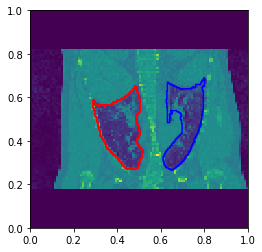

In [203]:
#init = 0
fin = 539
plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(line0_ten[init:fin,0], line0_ten[init:fin,1], '-r')
plt.plot(line0_ten_lo[init:fin,0], line0_ten_lo[init:fin,1], '-r')
init = 0
fin = 636
plt.plot(line1_ten[init:fin,0], line1_ten[init:fin,1], '-b')
#plt.plot(line1_ten_lo[init:fin,0], line1_ten_lo[init:fin,1], '-b')

In [102]:
diff = [torch.sum((p - line0[0])**2) for p in points]

In [103]:
line0[0]

tensor([0.4436, 0.2707])

In [104]:
diff[0]

tensor(6.2814e-06)

In [105]:
diff[18]

tensor(6.2814e-06)

In [108]:
diff

[tensor(6.2814e-06),
 tensor(2.5125e-05),
 tensor(5.6532e-05),
 tensor(0.0001),
 tensor(0.0002),
 tensor(0.0002),
 tensor(0.0003),
 tensor(0.0004),
 tensor(0.0005),
 tensor(0.0006),
 tensor(0.0008),
 tensor(0.0009),
 tensor(0.0011),
 tensor(0.0012),
 tensor(0.0014),
 tensor(0.0016),
 tensor(0.0018),
 tensor(0.0020),
 tensor(6.2814e-06),
 tensor(0.0020),
 tensor(8.1658e-05),
 tensor(5.0251e-05),
 tensor(3.1407e-05),
 tensor(2.5125e-05),
 tensor(0.0021),
 tensor(0.0023),
 tensor(0.0025),
 tensor(0.0028),
 tensor(0.0001),
 tensor(0.0028),
 tensor(0.0003),
 tensor(0.0002),
 tensor(0.0002),
 tensor(0.0029),
 tensor(0.0003),
 tensor(0.0029),
 tensor(0.0005),
 tensor(0.0005),
 tensor(0.0004),
 tensor(0.0030),
 tensor(0.0033),
 tensor(0.0006),
 tensor(0.0033),
 tensor(0.0008),
 tensor(0.0007),
 tensor(0.0034),
 tensor(0.0037),
 tensor(0.0009),
 tensor(0.0038),
 tensor(0.0013),
 tensor(0.0011),
 tensor(0.0010),
 tensor(0.0040),
 tensor(0.0014),
 tensor(0.0041),
 tensor(0.0018),
 tensor(0.0017),

In [107]:
torch.argmin(torch.tensor(diff))

tensor(18)

In [84]:
diff[245]

tensor(0.0565)

In [101]:
diff[0]

tensor(0.0025)

In [77]:
boundary0_pts.shape

torch.Size([540, 2])

In [75]:
len(points)

539

In [87]:
line0

tensor([0.4436, 0.2707])

In [88]:
points[0]

tensor([0.4461, 0.2707])

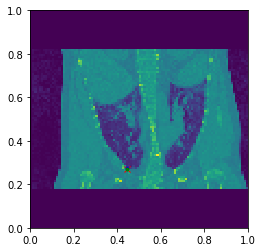

In [109]:
init = 0
fin = 1
plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
plt.plot(boundary0_pts[init:fin,0], boundary0_pts[init:fin,1], 'xr')
init = 19
fin = 20
plt.plot(boundary0_pts[init:fin,0], boundary0_pts[init:fin,1], '.b')
init = 1
fin = 2
plt.plot(boundary0_pts[init:fin,0], boundary0_pts[init:fin,1], '.g')

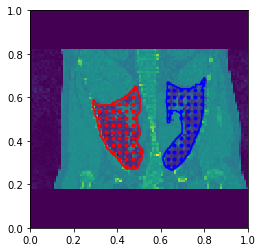

In [210]:

plt.imshow(source_deformable.geometry[0], origin='lower', extent=source_deformable.extent.totuple())
#plt.plot(boundary0_pts[::1,0], boundary0_pts[::1,1], '-r')
plt.plot(line0_ten_lo[:,0], line0_ten_lo[:,1], '-r')
plt.plot(line1_ten_lo[:,0], line1_ten_lo[:,1], '-b')
#plt.plot(boundary1_pts[:,0], boundary1_pts[:,1], '.b')
#plt.plot(pts[:,0], pts[:,1], '.g')
#plt.plot(pts_0_closed[:,0], pts_0_closed[:,1], '.r')
plt.plot(points_inside0[:,0], points_inside0[:,1], '.r')
plt.plot(points_inside1[:,0], points_inside1[:,1], '.b')
#plt.plot(model.modules[0].manifold[0].gd[:,0], model.modules[0].manifold[0].gd[:,1], '.r')
#plt.plot(model.modules[1].manifold[0].gd[:,0], model.modules[1].manifold[0].gd[:,1], '.b')
#plt.plot(model.modules[2].manifold[0].gd[:,0], model.modules[2].manifold[0].gd[:,1], '.g')

In [207]:
points_inside0 = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, source_deformable.extent, 1000., shape=line0_ten_lo)
points_inside1 = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, source_deformable.extent, 1000., shape=line1_ten_lo)


In [47]:
boundary0_pts_closed.shape

torch.Size([541, 2])

In [33]:
boundary0_pts_closed = torch.cat([boundary0_pts, boundary0_pts[0].unsqueeze(0)])
boundary0_closed = dm.MultiShape.Boundary(copy.copy(boundary0_pts_closed))
pts_0_closed = boundary0.isin_extract(pts)

In [125]:
sil = source_deformable.silent_module
pts = sil.manifold.gd

In [130]:
#%matplotlib qt5
plt.imshow(source, extent=source_deformable.extent.totuple(), origin='lower')
plt.plot(boundary0_pts[:,0], boundary0_pts[:,1], '.')
plt.plot(pts[::10,0], pts[::10,1], '.')


In [15]:
pts.shape

torch.Size([1600, 2])

In [16]:
source.shape

torch.Size([40, 40])

In [17]:
boundary0 = dm.MultiShape.Boundary(boundary0_pts)
boundary1 = dm.MultiShape.Boundary(boundary1_pts)

#source_deformable = dm.Models.DeformableImage(source, extent='match')
#target_deformable = dm.Models.DeformableImage(target, extent='match')


In [18]:
deformables = [source_deformable]

In [19]:
isinstance(source_deformable, dm.Models.DeformableImage)

True

In [20]:
pts = torch.tensor([])

In [21]:
pts = torch.cat([pts,source_deformable.silent_module.manifold.gd.clone()])

In [40]:
a = pts[:5].unsqueeze(0).transpose(1,2)
b = pts[:7].unsqueeze(2)

In [41]:
a.shape

torch.Size([1, 2, 5])

In [42]:
b.shape

torch.Size([7, 2, 1])

In [43]:
(a-b).shape

torch.Size([7, 2, 5])

In [37]:
for i, p in enumerate(pts):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
ind = torch.zeros(3, dtype=int)

In [23]:
a=boundary0.isin_label(pts)

In [34]:
(a.view(-1,1)*pts)

AttributeError: 'Tensor' object has no attribute 'nonzeros'

In [27]:
indi = a.nonzero()

In [28]:
a[indi]

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [56]:
boundary0.silent_module.manifold.gd.shape

torch.Size([540, 2])

In [8]:

module0 = 
module1 = 
module_bg = 

#we need attachment terms which take into account the segmentation
attach0 = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()
attach1 = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()
attachBg = dm.Attachment.EuclideanPointwiseDistanceAttachment_mask()

shoot_solver = 'torch_euler'
shoot_it = 10

compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold(
    [dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module0.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module1.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable.silent_module.manifold.clone(requires_grad=True), module_bg.manifold.clone(requires_grad=True), [boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]])])


SyntaxError: invalid syntax (<ipython-input-8-1b1121d61961>, line 7)

In [41]:
a = source -target
a = torch.mul(a, a)

In [42]:
a

tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000, 52430.5123, 52430.5123,  ..., 52430.5123, 52430.5123,
             0.0000],
        [    0.0000, 52430.5123,     0.0000,  ...,     0.0000, 52430.5123,
             0.0000],
        ...,
        [    0.0000, 52430.5123,     0.0000,  ...,     0.0000, 52430.5123,
             0.0000],
        [    0.0000, 52430.5123, 52430.5123,  ..., 52430.5123, 52430.5123,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000]])

In [31]:
source.shape, a.shape

(torch.Size([400, 400]), torch.Size([]))

In [ ]:
_, ind_nearest = torch.topk(normdiff, k=2, dim=1, largest=False)

In [102]:
a = torch.randn([20, 2])
asq = a.unsqueeze(0).transpose(1,2)
b = torch.randn([4, 2])

(-1.385257852746902,
 1.4071639615413092,
 -1.5860953949811232,
 2.135042526115916)

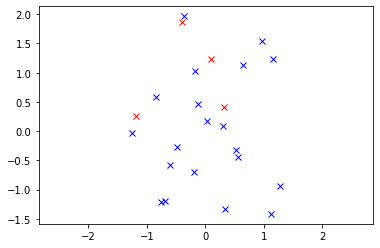

In [103]:
plt.plot(a[:,0], a[:,1], 'xb')
plt.plot(b[:,0], b[:,1], 'xr')
plt.axis('equal')

In [104]:
normdiff = torch.sum( (asq -b.unsqueeze(2))**2, dim=1)

In [105]:
normdiff.shape

torch.Size([4, 20])

In [106]:
_, ind_nearest = torch.topk(normdiff, k=2, dim=1, largest=False)

In [107]:
ind_nearest[:,]

tensor([[ 7, 14],
        [15,  3],
        [ 4,  7],
        [ 1, 11]])

In [108]:
diff_nearest = a[ind_nearest[:,1]] - a[ind_nearest[:,0]]
diff_pts = a[ind_nearest[:,0]] - b

In [144]:
ps = torch.sum(diff_nearest * diff_pts, dim=1)
no = torch.sum(diff_nearest * diff_nearest, dim=1)

ps.shape

t = - ps/no
t = t.unsqueeze(1)

proj = a[ind_nearest[:,0]] + t*diff_nearest

(-1.385257852746902,
 1.4071639615413092,
 -1.5860953949811232,
 2.135042526115916)

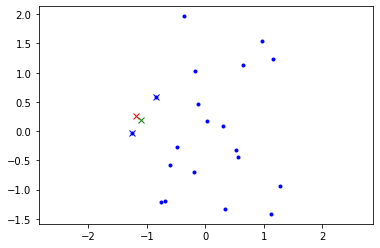

In [149]:
ind = 1
plt.plot(a[:,0], a[:,1], '.b')
plt.plot(a[ind_nearest[ind,0],0], a[ind_nearest[ind,0],1], 'xb')
plt.plot(a[ind_nearest[ind,1],0], a[ind_nearest[ind,1],1], 'xb')

plt.plot(b[ind,0], b[ind,1], 'xr')
ind
plt.plot(proj[ind,0], proj[ind,1], 'xg')
plt.axis('equal')

In [46]:
a[ind_nearest[:,0],0]

IndexError: index 3 is out of bounds for dimension 0 with size 3